<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/FXPROBOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the required libraries

In [ ]:
!pip install yfinance --user

In [16]:
import requests
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import yfinance as yf
from termcolor import colored as cl
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

# Data Extraction

In [76]:
#read data
df = pd.read_csv('/content/drive/MyDrive/data/eurusd30.csv', parse_dates=True)
# #setting index as date because some statsmodels might not work
df.index = pd.to_datetime(df['Time'])
df.head()

,Time,Open,High,Low,Close,Volume
Time,,,,,,
2010-01-01 00:00:00,2010-01-01 00:00:00,1.432840,1.432940,1.432265,1.432840,5.721000e+08
2010-01-01 00:30:00,2010-01-01 00:30:00,1.432825,1.432985,1.432340,1.432785,5.253000e+08
2010-01-01 01:00:00,2010-01-01 01:00:00,1.432885,1.432955,1.432090,1.432870,5.663000e+08
2010-01-01 01:30:00,2010-01-01 01:30:00,1.432735,1.433035,1.432135,1.432655,4.402000e+08
2010-01-01 02:00:00,2010-01-01 02:00:00,1.432900,1.433030,1.432295,1.432860,5.386000e+08


# Add RSI, MACD, CCI MA indicators to df

In [77]:
# constants
data_window = 1000
macd_slow = 26
macd_fast = 12
macd_smooth = 9
cci_ct = 0.015 #CCI = (AveP - SMA_of_AveP) / (0.015 * Mean Deviation)
cci_period = 20
rsi_period = 14

def get_macd(df, slow, fast, smooth):
    exp1 = df['Close'].ewm(span = fast, adjust = False).mean()
    exp2 = df['Close'].ewm(span = slow, adjust = False).mean()
    exp1_8 = df['Close'].ewm(span = fast*8, adjust = False).mean()
    exp2_8 = df['Close'].ewm(span = slow*8, adjust = False).mean()
    # 30Mn MACD
    df['macd'] = pd.DataFrame(exp1 - exp2)
    df['signal']  = pd.DataFrame(df['macd'].ewm(span = smooth, adjust = False).mean())
    df['hist'] = pd.DataFrame(df['macd'] - df['signal'])
    # 4Hour MACD
    df['macd8'] = pd.DataFrame(exp1_8 - exp2_8)
    df['signal8']  = pd.DataFrame(df['macd8'].ewm(span = smooth, adjust = False).mean())
    df['hist8'] = pd.DataFrame(df['macd8'] - df['signal8'])
    return df

def get_cci(df, n, constant): 
    TP = (df['High'] + df['Low'] + df['Close']) / 3 
    #moving_avg = ts_log.rolling(12).mean()
    CCI = pd.Series((TP - TP.rolling(n).mean()) / (constant * TP.rolling(n).std()), name = 'CCI_' + str(n)) 
    return CCI

def get_rsi(df, lookback):
    ret = df['Close'].diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(df['Close'].index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

macd = get_macd(df.head(data_window), macd_slow, macd_fast, macd_smooth)
macd['cci'] = get_cci(macd, cci_period, cci_ct)
macd['rsi'] = get_rsi(macd, rsi_period)

macd.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

,Time,Open,High,Low,Close,Volume,macd,signal,hist,macd8,signal8,hist8,cci,rsi
Time,,,,,,,,,,,,,,
2010-01-21 17:30:00,2010-01-21 17:30:00,1.409280,1.41009,1.408360,1.409290,8.503500e+08,-0.000146,-0.000641,0.000495,-0.008403,-0.008409,0.000005,67.765790,52.862506
2010-01-21 18:00:00,2010-01-21 18:00:00,1.410145,1.41106,1.409125,1.410680,8.009500e+08,0.000081,-0.000496,0.000577,-0.008366,-0.008400,0.000034,95.673593,55.969681
2010-01-21 18:30:00,2010-01-21 18:30:00,1.411270,1.41197,1.410785,1.411535,6.954500e+08,0.000326,-0.000332,0.000658,-0.008319,-0.008384,0.000065,115.427422,57.811835
2010-01-21 19:00:00,2010-01-21 19:00:00,1.410765,1.41110,1.409010,1.410045,6.916000e+08,0.000396,-0.000186,0.000582,-0.008288,-0.008365,0.000077,69.572466,53.602945
2010-01-21 19:30:00,2010-01-21 19:30:00,1.410330,1.41080,1.409675,1.410220,8.200000e+08,0.000460,-0.000057,0.000517,-0.008254,-0.008343,0.000088,67.362419,54.026293


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 180, in _repr_mimebundle_
    dataframe = self._preprocess_dataframe()
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 168, in _preprocess_dataframe
    dataframe = dataframe.reset_index()
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 4859, in reset_index
    new_obj.insert(0, name, level_values)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 3628, in insert
    self._mgr.insert(loc, column, value, allow_duplicates=allow_duplicates)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/internals/managers.py", line 1186, in insert
    raise ValueError(f"cannot insert {item}, already exists")
ValueError: cannot insert Time, already exists
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 192, in _repr_javascript_mod

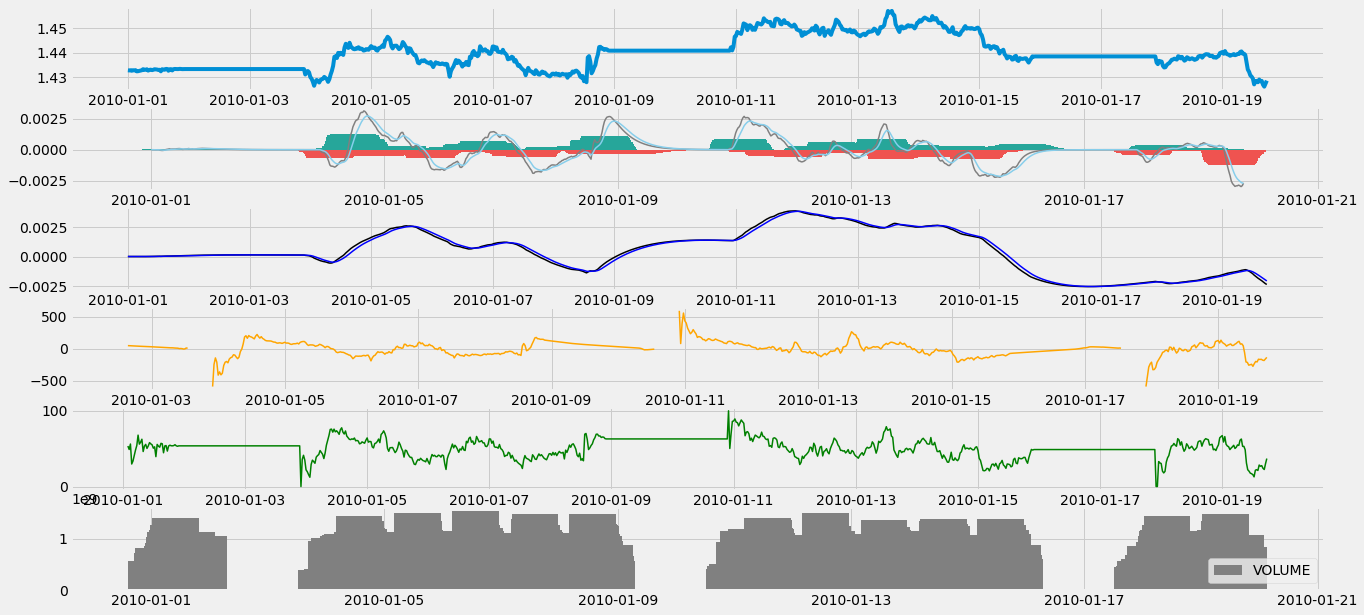

In [75]:
# Plot MACD
def plot_macd(prices, df):
    ax_price = plt.subplot2grid((6,1), (0,0),  colspan = 1)
    ax_macd = plt.subplot2grid((6,1), (1,0), colspan = 1)
    ax_macd8 = plt.subplot2grid((6,1), (2,0), colspan = 1)
    ax_cci = plt.subplot2grid((6,1), (3,0), colspan = 1)
    ax_rsi = plt.subplot2grid((6,1), (4,0), colspan = 1)
    ax_volume = plt.subplot2grid((6,1), (5,0), colspan = 1)

    ax_price.plot(prices)
    ax_macd.plot(df['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
    ax_macd.plot(df['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
    ax_macd8.plot(df['macd8'], color = 'black', linewidth = 1.5, label = 'MACD8')
    ax_macd8.plot(df['signal8'], color = 'blue', linewidth = 1.5, label = 'SIGNAL8')
    ax_cci.plot(df['cci'], color = 'orange', linewidth = 1.5, label = 'CCI')
    ax_rsi.plot(df['rsi'], color = 'green', linewidth = 1.5, label = 'RSI')
    ax_volume.bar(prices.index, df['Volume'], color = 'grey', label = 'VOLUME')


    for i in range(len(prices)):
        if str(df['hist'][i])[0] == '-':
            ax_macd.bar(prices.index[i], df['hist'][i], color = '#ef5350')
        else:
            ax_macd.bar(prices.index[i], df['hist'][i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(macd['Close'], macd)

# Implement Decision Tree Model